In [1]:
import h5py

import fenics as fe
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, "../scripts")

from swe import ShallowTwo

In [3]:
def plot_fields_curr(swe, t):
    x_vertices = swe.mesh.coordinates()
    n_vertices = len(x_vertices)
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])

    x, y = x_vertices[:, 0], x_vertices[:, 1]

    fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(9, 6))

    im = axs[0].tricontourf(x, y, u1, 64)
    axs[0].set_title(r"$u_1$")
    cbar = fig.colorbar(im, ax=axs[0])

    im = axs[1].tricontourf(x, y, u2, 64)
    axs[1].set_title(r"$u_2$")
    cbar = fig.colorbar(im, ax=axs[1])

    im = axs[2].tricontourf(x, y, h, 64, cmap="coolwarm")
    axs[2].set_title(r"$h$")
    cbar = fig.colorbar(im, ax=axs[2])

    for ax in axs:
        ax.set_ylabel(r"$y$")
    axs[-1].set_xlabel(r"$x$")


def plot_quiver_curr(swe, t):
    x_vertices = swe.mesh.coordinates()
    n_vertices = len(x_vertices)
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])

    x, y = x_vertices[:, 0], x_vertices[:, 1]
    fig, ax = plt.subplots(1, 1, figsize=(9, 4))
    ax.quiver(x, y, u1, u2)
    ax.set_xlabel(r"$x$")
    ax.set_ylabel(r"$y$")
    ax.set_title(f"Velocity field at time t = {t:.5f}")
    

mesh_file = "../mesh/channel-piggott.xdmf"
def read_model(model_output_file, idx):
    swe = ShallowTwo(mesh=mesh_file,
                     control={
                         "dt": 1e-3,
                         "theta": 1,
                         "integrate_continuity_by_parts": True,
                         "simulation": "cylinder",
                         "laplacian": False,
                         "les": True
                     })

    x_vertices = swe.mesh.coordinates()
    x, y = x_vertices[:, 0], x_vertices[:, 1]
    n_vertices = len(x_vertices)

    vec_name = f"/du/vector_{idx}"
    checkpoint = fe.HDF5File(swe.mesh.mpi_comm(), model_output_file, "r")
    checkpoint.read(swe.du, vec_name)  # read into du
    t = checkpoint.attributes(vec_name)["timestamp"]
    return swe, t


def extract_fields(swe, n_vertices):
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])
    return (u1, u2, h)

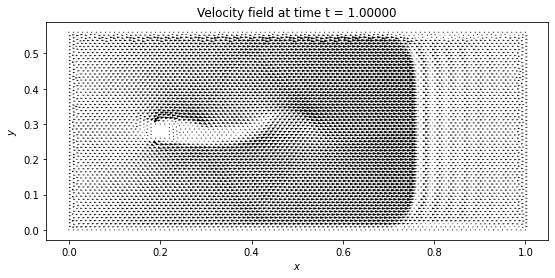

In [4]:
swe_euler, t = read_model("../outputs/swe-channel-alt-ts-theta-1.0-checkpoint.h5", 10)
swe_cn, t = read_model("../outputs/swe-channel-alt-ts-theta-0.5-checkpoint.h5", 10)
swe_cn6, t = read_model("../outputs/swe-channel-alt-ts-theta-0.6-checkpoint.h5", 10)
swe_reference, t = read_model("../outputs/swe-channel-alt-ts-theta-1.0-reference.h5", 100)

plot_quiver_curr(swe_reference, t)
plt.show()
plt.close()
# plot_quiver_curr(swe_reference, t)
# plt.show()
# plt.close()

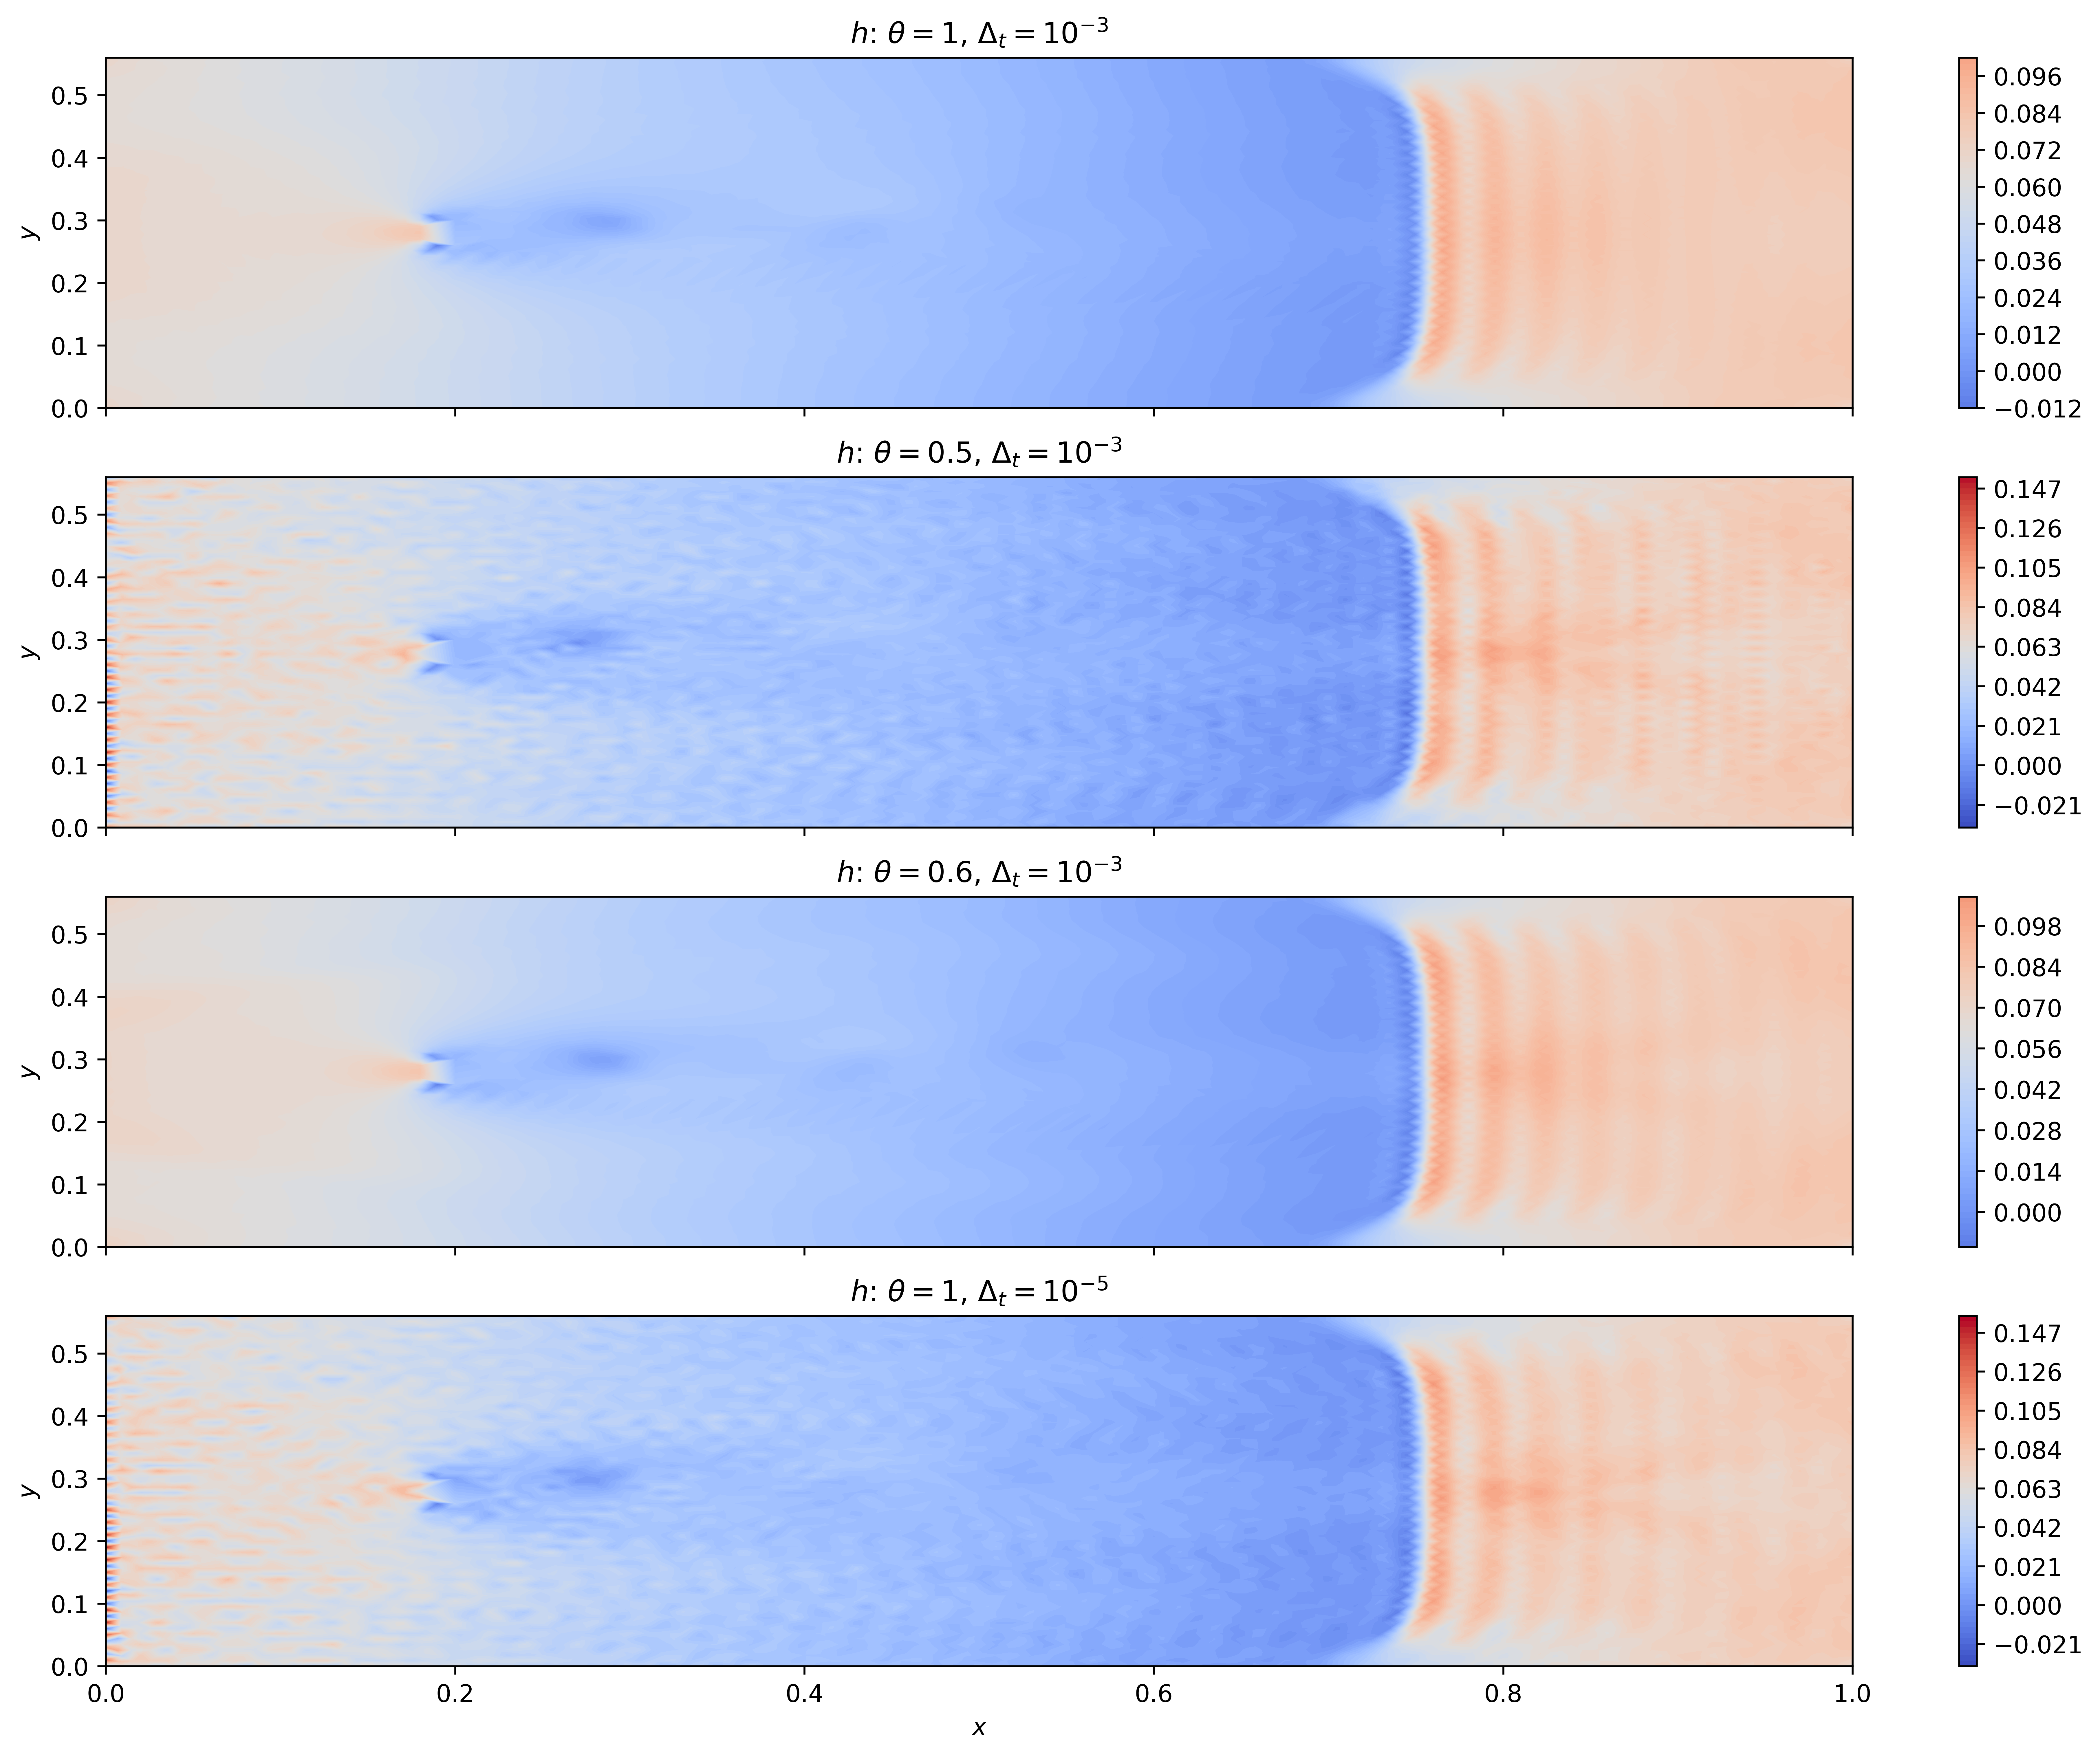

In [5]:
titles = [fr"$h$: $\theta = 1$, $\Delta_t = 10^{{-3}}$",
          fr"$h$: $\theta = 0.5$, $\Delta_t = 10^{{-3}}$",
          fr"$h$: $\theta = 0.6$, $\Delta_t = 10^{{-3}}$",
          fr"$h$: $\theta = 1$, $\Delta_t = 10^{{-5}}$"]
swes = [swe_euler, swe_cn, swe_cn6, swe_reference]
h_fields = []

for swe in swes:
    x_vertices = swe.mesh.coordinates()
    n_vertices = len(x_vertices)
    du_vec = swe.du.compute_vertex_values()
    u1, u2, h = (du_vec[:n_vertices], du_vec[n_vertices:(2 * n_vertices)],
                 du_vec[(2 * n_vertices):])

    x, y = x_vertices[:, 0], x_vertices[:, 1]

    h_fields.append(h)

def get_min_max(x):
    return np.amin(x), np.amax(x)

h_min, h_max = get_min_max(np.asarray(h_fields))
n_plot = len(h_fields)

fig, axs = plt.subplots(n_plot, 1, constrained_layout=True, figsize=(12, 10),
                        dpi=600, sharex=True, sharey=True)

for i, h in enumerate(h_fields):
    im = axs[i].tricontourf(x, y, h, 64, cmap="coolwarm", vmin=h_min, vmax=h_max)
    axs[i].set_title(titles[i])
    cbar = fig.colorbar(im, ax=axs[i])

for ax in axs:
    ax.set_ylabel(r"$y$")
axs[-1].set_xlabel(r"$x$")
plt.show()
plt.close()

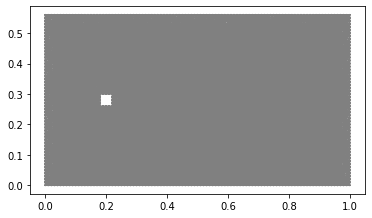

In [6]:
# plot the mesh
fe.plot(swe.mesh)
plt.show()
plt.close()

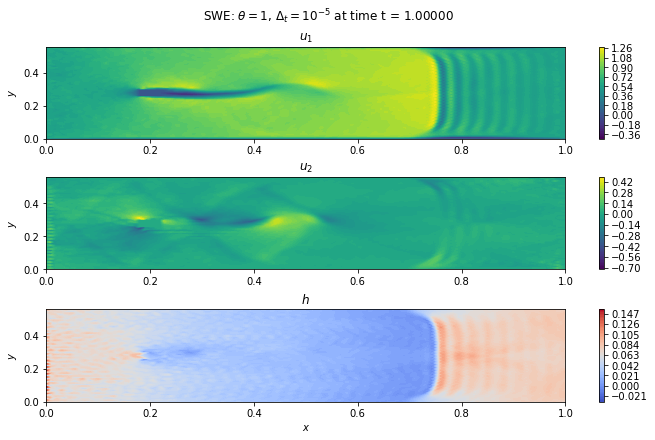

In [7]:
# plot the solution field
plot_fields_curr(swe_reference, t)
plt.suptitle(fr"SWE: $\theta = 1$, $\Delta_t = 10^{{-5}}$ at time t = {t:.5f}")
plt.show()
plt.close()

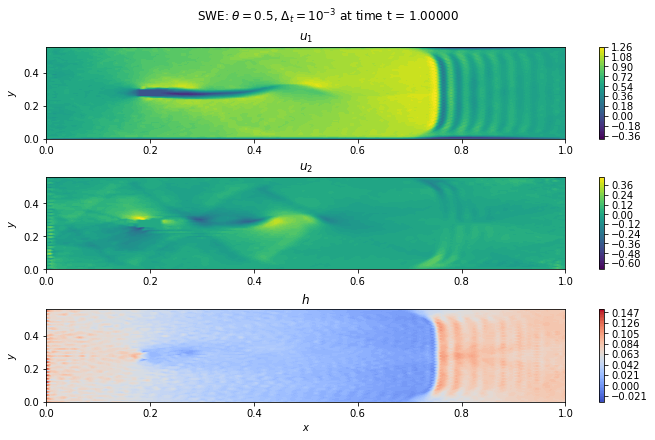

In [8]:
# plot the solution field
plot_fields_curr(swe_cn, t)
plt.suptitle(fr"SWE: $\theta = 0.5$, $\Delta_t = 10^{{-3}}$ at time t = {t:.5f}")
plt.show()
plt.close()

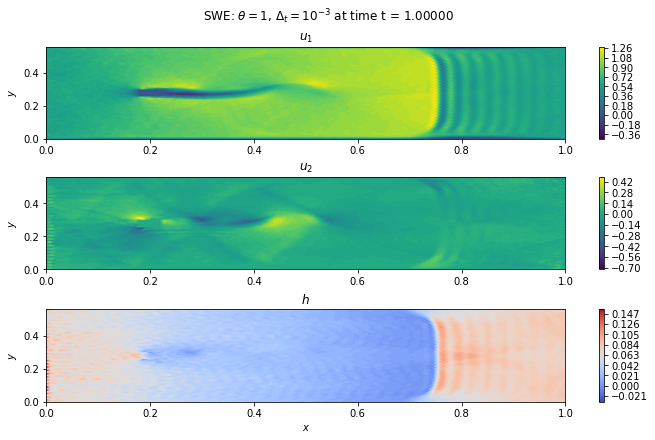

In [9]:
# plot the solution field
plot_fields_curr(swe, t)
plt.suptitle(fr"SWE: $\theta = 1$, $\Delta_t = 10^{{-3}}$ at time t = {t:.5f}")
plt.show()
plt.close()

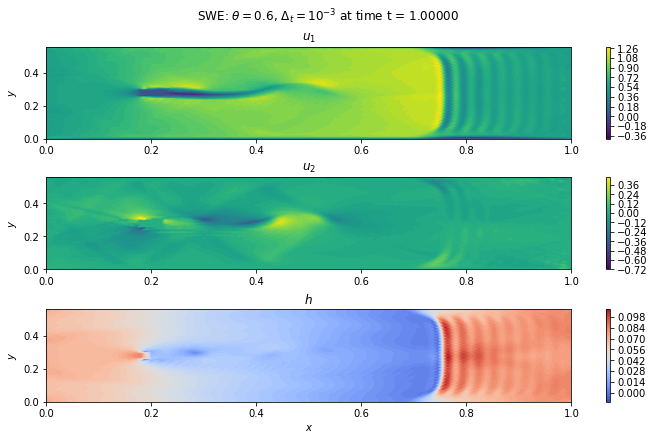

In [10]:
# plot the solution field
plot_fields_curr(swe_cn6, t)
plt.suptitle(fr"SWE: $\theta = 0.6$, $\Delta_t = 10^{{-3}}$ at time t = {t:.5f}")
plt.show()
plt.close()

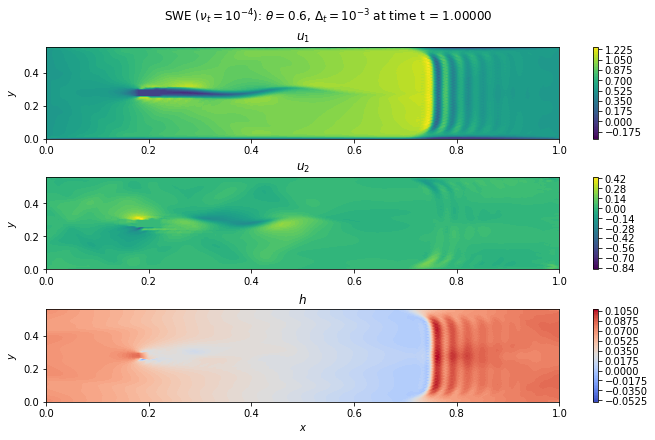

In [11]:
swe_laplacian, t = read_model("../outputs/swe-channel-specified-damping.h5", 10)
plot_fields_curr(swe_laplacian, t)
plt.suptitle(fr"SWE ($\nu_t = 10^{{-4}}$): $\theta = 0.6$, $\Delta_t = 10^{{-3}}$ at time t = {t:.5f}")
plt.show()
plt.close()

In [15]:
print(fe.errornorm(swe_laplacian.du, swe_reference.du))
print(fe.errornorm(swe_cn.du, swe_reference.du))
print(fe.errornorm(swe_cn6.du, swe_reference.du))
print(fe.errornorm(swe_laplacian.du, swe_cn6.du) / fe.norm(swe_cn6.du))

*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.04384182542080353
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.03350150580002613
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
0.02427077037708658
*** Warning: Degree of exact solution may be inadequate for accurate result in errornorm.
Calling FFC just-in-time (JIT) compiler, this may take some time.
0.06292258047969247
